ValueError: num must be 1 <= num <= 4, not 5

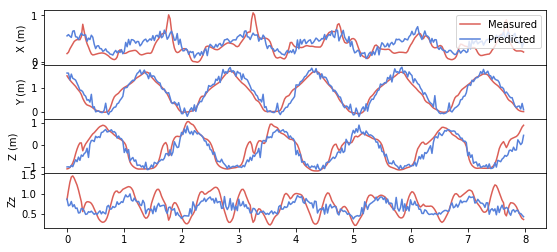

In [11]:
import h5py, glob
import numpy as np
from datetime import datetime
from matplotlib import pyplot
from scipy.interpolate import interp1d
from pandas import DataFrame, concat
from math import sqrt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from pickle import dump
import tensorflow as tf

gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

def load_measurement(kind="arm_push", subject="Tassos", i=1):
    filename = subject+"_"+kind+"_0"+str(i)+"*.h5"
    measfile = glob.glob(rootpath+filename)[0]
    with h5py.File(measfile, "r") as f:
        # List all groupsl
        #print("Keys: %s" % f.keys())
        a_group_key = list(f.keys())[0]
        if 'Joint values' in f.keys():
            joint_data = np.array(f['Joint values'])
        else:
            joint_data = np.array(f['Body markers'])
            
        emg_data = np.array(f['emg signals'])

    f = interp1d(emg_data[:,0], emg_data[:,1:], axis=0, bounds_error=False, fill_value='extrapolate', kind='linear')
    emg_data = f(joint_data[:,0])

    data = np.concatenate((emg_data,joint_data[:,1:5]), axis=1)
    values = data[100:-100,:]
    return values

def series_to_supervised(data, n_in=1, n_out=1, features=range(6,10,1), dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    df = DataFrame(data[:,features])
    for i in range(0, n_out, 1):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in features]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in features]
    
    agg = concat(cols, axis=1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def preprocess_data(series, n_lag=1, n_steps=1, out_features=range(0,1,1), scaler_emg=None, scaler_joints=None):
    values = series.astype('float32')
    if scaler_emg is None:
        scaler_emg = MinMaxScaler(feature_range=(0,1))
        scaler_joints = MinMaxScaler(feature_range=(0,1))
        scaled = np.concatenate((scaler_emg.fit_transform(values[:,0:min(out_features)]), scaler_joints.fit_transform(values[:,out_features])),axis=1)
    else:
        scaled = np.concatenate((scaler_emg.transform(values[:,0:min(out_features)]), scaler_joints.transform(values[:,out_features])),axis=1)
    dump(scaler_emg, open(rootpath+"../models/"+subject+'_'+kind+'_scaler_emg.pkl', 'wb'), protocol=2)
    dump(scaler_joints, open(rootpath+"../models/"+subject+'_'+kind+'_scaler_joint.pkl', 'wb'), protocol=2)
    reframed = series_to_supervised(scaled, n_lag, n_steps, out_features)
    return reframed, scaler_emg, scaler_joints

def split_datasets(series, train_per=0.6, n_lag=1, n_steps=1, n_in_features=1, n_out_features=1):
    values = series.values
    values = values[:int(np.floor(values.shape[0]/n_steps)*n_steps),:]
    train_k = int(round(values.shape[0]*train_per/n_steps)*n_steps)
    n_obs = n_lag * n_in_features
    train = values[:train_k,:]
    test = values[train_k:,:]
    train_X, train_Y = train[:, :n_obs], train[:, -n_out_features*n_steps:]
    test_X, test_Y = test[:, :n_obs], test[:, -n_out_features*n_steps:]

    train_X = train_X.reshape((train_X.shape[0], n_lag, n_in_features))
    test_X = test_X.reshape((test_X.shape[0], n_lag, n_in_features))
    return train_X, train_Y, test_X, test_Y

def train_model(train_X, train_Y, test_X, test_Y, kind="arm_push", n_steps=1):
    n_lag = train_X.shape[1]
    n_in_features = train_X.shape[2]
    n_out_features = int(train_Y.shape[1]/n_steps)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)
    mc = ModelCheckpoint(rootpath+"../models/"+kind+"_model.h5", monitor='val_loss', mode='min', verbose=0, save_best_only=True)

    model = Sequential()
    model.add(LSTM(20, input_shape=(n_lag, n_in_features), return_sequences=True))
    model.add(LSTM(150, return_sequences=True))
    model.add(LSTM(20))
    model.add(Dense(n_steps*n_out_features))
    model.compile(loss='mae', optimizer='adam')
    
    model.fit(train_X, train_Y, epochs=4000, batch_size=n_steps*20, validation_data=(test_X, test_Y), verbose=0, shuffle=False, callbacks=[es, mc])
    model.reset_states()
    return model

def update_model(model, train_X, train_Y, test_X, test_Y):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    mc = ModelCheckpoint(rootpath+"../models/"+kind+"_model.h5", monitor='val_loss', mode='min', verbose=0, save_best_only=True)
    model.fit(train_X, train_Y, validation_data=(test_X, test_Y), epochs=1, verbose=0, shuffle=False, callbacks=[es, mc])
    model.reset_states()
    return model

def dgm(qs):
    hp = np.empty((3,qs.shape[0]), float)
    hp[0,:] = 0.3*np.cos(qs[:,0])*np.cos(qs[:,1]) + 0.15 + 0.25*((np.sin(qs[:,0])*np.sin(qs[:,2]) + np.sin(qs[:,1])*np.cos(qs[:,0])*np.cos(qs[:,2]))*np.sin(qs[:,3]) + np.cos(qs[:,0])*np.cos(qs[:,1])*np.cos(qs[:,3]))
    hp[1,:] = 0.3*np.sin(qs[:,0])*np.cos(qs[:,1]) + 0.25*((np.sin(qs[:,0])*np.sin(qs[:,1])*np.cos(qs[:,2]) - np.sin(qs[:,2])*np.cos(qs[:,0]))*np.sin(qs[:,3]) + np.sin(qs[:,0])*np.cos(qs[:,1])*np.cos(qs[:,3]))
    hp[2,:] = 0.3*np.sin(qs[:,1]) + 0.25*(np.sin(qs[:,1])*np.cos(qs[:,3]) - np.sin(qs[:,3])*np.cos(qs[:,1])*np.cos(qs[:,2]))
    return hp
    
def plot_validation(hp_hat, hp):
    i = 1
    labels = ['X (m)','Y (m)','Z (m)','Zz']
    fig = pyplot.figure(figsize=(9, 4))
    fig.subplots_adjust(hspace=0)
    for group in range(hp_hat.shape[0]):
        ax = pyplot.subplot(hp_hat.shape[1], 1, i)
        pyplot.plot(np.arange(0,float(hp.shape[0]))/40, hp[:,group], '#db5f57', label='Measured')
        pyplot.plot(np.arange(0,float(hp_hat.shape[0]))/40, hp_hat[:,group], '#5781db', label='Predicted')
        ax.set_ylabel(labels[i-1])
        if i==1:
            pyplot.legend(loc='upper right')
        if i==hp_hat.shape[0]:
            ax.set_xlabel('time (s)')
        i += 1
        
    fig.show()
    #fig.set_size_inches(12,5)
    #fig.savefig('prediction.png', bbox_inches='tight', pad_inches=0)
    pyplot.pause(1)
    
def validate_model(model, test_X, test_Y, n_steps, n_out_features, scaler, verbose=False):
    yhat = model.predict(test_X[np.arange(0,test_X.shape[0],n_steps),:,:])
    yhat = yhat.reshape(yhat.shape[0]*n_steps,n_out_features)

    inv_yhat = scaler.inverse_transform(yhat)
    test_y = test_Y[np.arange(0,test_Y.shape[0],n_steps),:]
    inv_y = scaler.inverse_transform(test_y.reshape(test_y.shape[0]*n_steps, n_out_features))

    if verbose:
        plot_validation(inv_yhat, inv_y)
    
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)
    return rmse

kind="arm_raise"
date="20190418"
subject="Tassos"
rootpath = "/data/tassos/intention_measurements/combined/"+date+"/training/"+subject+"/"
values = load_measurement(kind, i=1)

n_lag = 40
n_steps = 40
train_per = 0.6
out_features = range(6,10,1)
n_out_features = len(out_features)
n_in_features = values.shape[1]

scaler_emg, scaler_joints = None, None
values = load_measurement(kind, subject, i=1)
values = np.append(values,load_measurement(kind, subject, i=2),axis=0)
processed, scaler_emg, scaler_joints = preprocess_data(values, n_lag, n_steps, out_features, scaler_emg, scaler_joints)
train_X, train_Y, test_X, test_Y = split_datasets(processed, train_per, n_lag, n_steps, n_in_features, n_out_features)
model = train_model(train_X, train_Y, test_X, test_Y, kind, n_steps)
rmse1 = validate_model(model, test_X, test_Y, n_steps, n_out_features, scaler_joints, verbose=True)

In [9]:
values = load_measurement(kind, i=2)
processed, scaler = preprocess_data(values, n_lag, n_steps, out_features)
train_X, train_Y, test_X, test_Y = split_datasets(processed, train_per, n_lag, n_steps, n_in_features, n_out_features)
model = update_model(model, train_X[:n_steps,:,:], train_Y[:n_steps,:], test_X[:n_steps,:,:], test_Y[:n_steps,:])
rmse2 = validate_model(model, test_X, test_Y, n_steps, n_out_features, scaler)

values = load_measurement(kind, i=3)
processed, scaler = preprocess_data(values, n_lag, n_steps, out_features)
train_X, train_Y, test_X, test_Y = split_datasets(processed, 0, n_lag, n_steps, n_in_features, n_out_features)
rmse2 = validate_model(model, test_X, test_Y, n_steps, n_out_features, scaler)

ValueError: too many values to unpack